#**All the questions have been completed and the Complete Assignment was done Induvidually.**
**Sources referred are cited at the end **

In [1]:
## Imports
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
import keras
import keras.backend as K

#Displaying a few training and testing images and their masks

##Training Data and their Masks

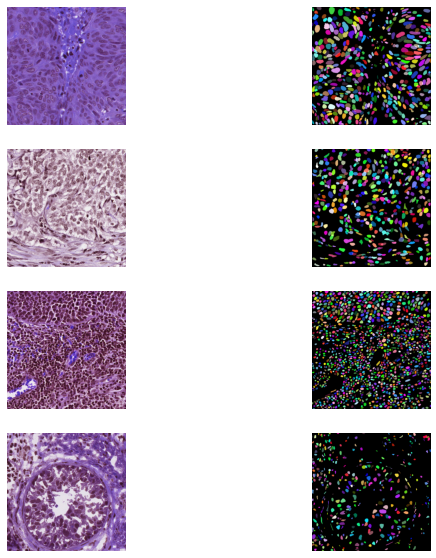

In [2]:
i_1=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-18-5592-01Z-00-DX1.png')
o_1=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-18-5592-01Z-00-DX1.png')
i_2=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-21-5786-01Z-00-DX1.png')
o_2=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-21-5786-01Z-00-DX1.png')
i_3=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-AY-A8YK-01A-01-TS1.png')
o_3=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-AY-A8YK-01A-01-TS1.png')
i_4=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-G2-A2EK-01A-02-TSB.png')
o_4=cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-G2-A2EK-01A-02-TSB.png')
i_list=[i_1,i_2,i_3,i_4]
o_list=[o_1,o_2,o_3,o_4]
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.axis('off')
    plt.imshow(i_list[i])
    plt.subplot(4,2,2*(i+1))
    plt.axis('off')
    plt.imshow(o_list[i])
plt.show()


##Testing Data and their Masks

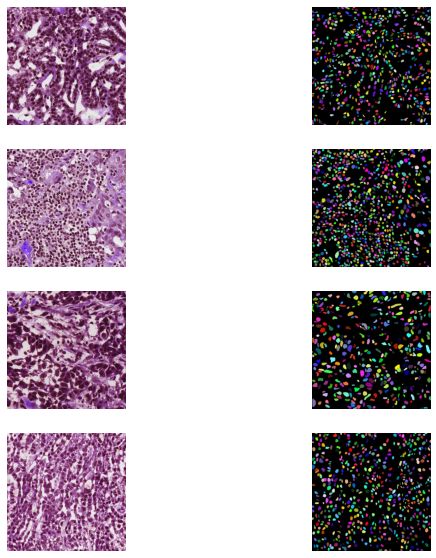

In [3]:
i_1=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-2Z-A9J9-01A-01-TS1.png')
o_1=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-2Z-A9J9-01A-01-TS1.png')
i_2=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-44-2665-01B-06-BS6.png')
o_2=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-44-2665-01B-06-BS6.png')
i_3=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-AO-A0J2-01A-01-BSA.png')
o_3=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-AO-A0J2-01A-01-BSA.png')
i_4=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-IZ-8196-01A-01-BS1.png')
o_4=cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-IZ-8196-01A-01-BS1.png')
i_list=[i_1,i_2,i_3,i_4]
o_list=[o_1,o_2,o_3,o_4]
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.axis('off')
    plt.imshow(i_list[i])
    plt.subplot(4,2,2*(i+1))
    plt.axis('off')
    plt.imshow(o_list[i])
plt.show()

#**Coding a basic UNet for semantic segmentation in TF+Keras for the binary nucleus vs. non-nucleus segmentation**

## **Using Datgen Class to Generate Data**

https://www.youtube.com/watch?v=QhDlmPhFkNk(Recommended by Sir to watch) was referred for creating the Datagen Block

In [4]:
class Datgen(keras.utils.Sequence):
    #This is the Data Generator Class
    def __init__(self, ids, path, batch_size=8, image_size=128):  #using a standard batch_size of 8 as default
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

  #defining a function to load the image and mask from the given folder      
    def __load__(self, id_name):

        #Using os.path.join() method to join various path components 
        image_path = os.path.join(self.path,  "Tissue-Images/", id_name) 
        mask_path = os.path.join(self.path, "Binary-Mask/",id_name)
        
        # Reading Image
        image = cv2.imread(image_path, 1)
        

        #To test whether the image read is empty or not
        if (type(image)==type(None)):
            print(image_path)
        else:
            
            image = cv2.resize(image, (self.image_size, self.image_size))
        mask=cv2.imread(mask_path,0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
            
        #Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        #initializing an empty array for image and mask and later appending them
        image = [] 
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)# Converting image into a numpy array
        mask  = np.array(mask)# Converting mask into a numpy array
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

###Defining training paths and ids

In [5]:
image_size = 128

#Defining the training path and the testing path
train_path = "/content/drive/MyDrive/MoNuSeg-Training-Data/"
train_path_tissue = "/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/"
train_path_colored_tissue= "/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/"
test_path = "/content/drive/MyDrive/MoNuSeg-Test-Data/"
test_path_tissue = "/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/"
test_path_colored_tissue="/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/"
epochs = 5
batch_size = 8

## Training and Testing Ids
train_ids = next(os.walk(train_path_tissue))[2]
valid_ids = next(os.walk(test_path_tissue))[2]
color_ids= next(os.walk(test_path_tissue))[2]
test_color_ids=next(os.walk(test_path_colored_tissue))[2]
train_color_ids=next(os.walk(train_path_colored_tissue))[2]

gen = Datgen(train_ids, train_path, batch_size=len(train_ids), image_size=image_size)
gen_color_train=Datgen(train_color_ids, train_path, batch_size=8, image_size=image_size)
gen_color_test=Datgen(test_color_ids, test_path, batch_size=8, image_size=image_size)

##Augmenting the Data

###Data is being Augmented by rotating the image so as to increase the training data and the testing data

####Augmenting the Training *Data*

float64 (30, 128, 128, 1)
float64 (30, 128, 128, 1)


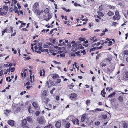

In [6]:
x, y = gen.__getitem__(0)
print(y.dtype,y.shape)
u=np.zeros((x.shape[0]*4,x.shape[1],x.shape[2],x.shape[3]),"float64")
v=np.zeros((x.shape[0]*4,x.shape[1],x.shape[2],y.shape[3]),"float64")
print(y.dtype,y.shape)


for ind in range(x.shape[0]):
    u[ind,:,:,:]=x[ind,:,:,:]
    #Flipping the input image horizontally and vertically
    u[len(train_ids)+3*ind,:,:,:]=x[ind,::-1,:,:]
    u[len(train_ids)+3*ind+1,:,:,:]=x[ind,:,::-1,:]
    u[len(train_ids)+3*ind+2,:,:,:]=x[ind,::-1,::-1,:]

for ind in range(y.shape[0]):
    #Flipping the output image horizontally and vertically
    v[ind,:,:,:]=y[ind,:,:,:]
    v[len(train_ids)+3*ind,:,:,:]=v[ind,::-1,:,:]
    v[len(train_ids)+3*ind+1,:,:,:]=v[ind,:,::-1,:]
    v[len(train_ids)+3*ind+2,:,:,:]=v[ind,::-1,::-1,:]
cv2_imshow(u[51]*255)

####Augmenting the Validation *Data*

float64 (14, 128, 128, 1)


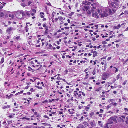

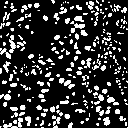

In [7]:
valid_gen = Datgen(valid_ids, test_path, image_size=image_size, batch_size=len(train_ids))
x2, y2 = valid_gen.__getitem__(0)
print(y2.dtype,y2.shape)
w=np.zeros((x2.shape[0]*4,x2.shape[1],x2.shape[2],x2.shape[3]),"float64")
l=np.zeros((x2.shape[0]*4,x2.shape[1],x2.shape[2],y2.shape[3]),"float64")

for ind in range(x2.shape[0]):
    #Flipping the input image horizontally and vertically
    w[ind,:,:,:]=x2[ind,:,:,:]
    w[x2.shape[0]+3*ind,:,:,:]=x2[ind,::-1,:,:]
    w[x2.shape[0]+3*ind+1,:,:,:]=x2[ind,:,::-1,:]
    w[x2.shape[0]+3*ind+2,:,:,:]=x2[ind,::-1,::-1,:]
for ind in range(y2.shape[0]):
    #Flipping the input image horizontally and vertically
    l[ind,:,:,:]=y[ind,:,:,:]
    l[x2.shape[0]+3*ind,:,:,:]=y[ind,::-1,:,:]
    l[x2.shape[0]+3*ind+1,:,:,:]=y[ind,:,::-1,:]
    l[x2.shape[0]+3*ind+2,:,:,:]=y[ind,::-1,::-1,:]
cv2_imshow(w[23]*255)
cv2_imshow(l[23]*255)

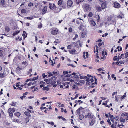

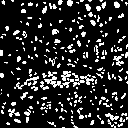

In [8]:
cv2_imshow(u[52]*255)
cv2_imshow(v[52]*255)

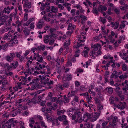

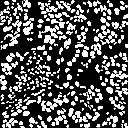

In [9]:
r = random.randint(0, 7)
cv2_imshow(x[r]*255)
cv2_imshow(y[r]*255)

##DownSampling block

In [17]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    
    #It consists of two 3x3 convolutions each of which is followed by a rectified linear unit 
    #It also consists of a 2x2 max pooling operation with stride 2 for downsampling.
    #At each downsampling step we double the number of feature channels

    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    #changing the input
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    #pooling operation
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

#Defining UNet And Training it using Dice Loss

##Defining Dice Loss

internet was referred for definition and idea for diceloss function

In [13]:
def diceloss(out, inp, e=1e-6):
    inputs = K.flatten(inp)
    targets = K.flatten(out)
    intersection = K.sum(inputs*targets)
    dice = (2*intersection+e ) / (K.sum(targets) + K.sum(inputs)+e )
    return (1-dice)

In [ ]:
def UNet():
    #feature maps

    filters= [16, 32, 64, 128, 256] #Gives the array of no. of filters used in a block
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)

    return model
model = UNet()
model.compile(optimizer="adam", loss=diceloss, metrics=["acc"])
model.summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1027 (Conv2D)           (None, 128, 128, 16  448         ['input_54[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_1028 (Conv2D)           (None, 128, 128, 16  2320        ['conv2d_1027[0][0]']            
                                )                                                          

In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=5)

Epoch 1/5
15/15 [==============================] - 28s 2s/step - loss: 0.5827 - acc: 0.2355 - val_loss: 0.6699 - val_acc: 0.1765
Epoch 2/5
15/15 [==============================] - 29s 2s/step - loss: 0.5829 - acc: 0.2355 - val_loss: 0.6699 - val_acc: 0.1765
Epoch 3/5
15/15 [==============================] - 30s 2s/step - loss: 0.5830 - acc: 0.2355 - val_loss: 0.6699 - val_acc: 0.1765
Epoch 4/5
15/15 [==============================] - 40s 3s/step - loss: 0.5827 - acc: 0.2355 - val_loss: 0.6699 - val_acc: 0.1765
Epoch 5/5
15/15 [==============================] - 27s 2s/step - loss: 0.5831 - acc: 0.2355 - val_loss: 0.6699 - val_acc: 0.1765


In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=5)

Epoch 1/5
15/15 [==============================] - 123s 2s/step - loss: 0.9302 - acc: 0.6855 - val_loss: 0.9992 - val_acc: 0.7788
Epoch 2/5
15/15 [==============================] - 26s 2s/step - loss: 0.9308 - acc: 0.6854 - val_loss: 0.9992 - val_acc: 0.7788
Epoch 3/5
15/15 [==============================] - 26s 2s/step - loss: 0.9309 - acc: 0.6854 - val_loss: 0.9992 - val_acc: 0.7788
Epoch 4/5
15/15 [==============================] - 31s 2s/step - loss: 0.9300 - acc: 0.6853 - val_loss: 0.9992 - val_acc: 0.7788
Epoch 5/5
15/15 [==============================] - 26s 2s/step - loss: 0.9296 - acc: 0.6857 - val_loss: 0.9992 - val_acc: 0.7788


## Dice Score on Training Data

In [12]:
#Defining Dice Score
def dicescore(inp,out,e=1e-6):
    inp=inp.astype('float64')
    out=out.astype('float64')
    inp=inp.ravel()
    out=out.ravel()
    #Flattening input and output and converting them into float
    intersection=np.sum(inp*out)
    dice=(intersection*2 )/(np.sum(inp)+np.sum(out))
    return  dice #returning dice loss

(8, 128, 128, 3)
1/1 [==============================] - 1s 675ms/step
[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


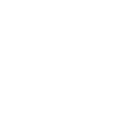

0.4608904470000672

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(train_ids, train_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
print(result[5])
cv2_imshow(result[5]*255)
dicescore(result,y)

Dice Score on Training Data comes out to be 0.461

## Dice Score on Testing Data

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(valid_ids, test_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
dicescore(result,y)

(8, 128, 128, 3)
1/1 [==============================] - 0s 432ms/step


0.35040809869263656

(8, 128, 128, 3)
1/1 [==============================] - 1s 684ms/step
0.3503904584172749
[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


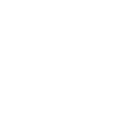

In [ ]:
model.save_weights("UNetW.h5")
gen = Datgen(valid_ids, test_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
print(dicescore(result,y))
print(result[0])
cv2_imshow(result[1]*255)

Dice Score on Testing Data comes out to be 0.35041

#Training using MSE




In [ ]:
def UNet():
    #feature maps

    filters= [16, 32, 64, 128, 256] #Gives the array of no. of filters used in a block
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)

    return model
model = UNet()
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["acc"])

In [ ]:
def UNet():
    #feature maps

    filters= [16, 32, 64, 128, 256] #Gives the array of no. of filters used in a block
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)

    return model
model = UNet()
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["acc"])

In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=20)

Epoch 1/20
15/15 [==============================] - 44s 3s/step - loss: 0.2206 - acc: 0.6489 - val_loss: 0.1548 - val_acc: 0.7792
Epoch 2/20
15/15 [==============================] - 33s 2s/step - loss: 0.1839 - acc: 0.7056 - val_loss: 0.1510 - val_acc: 0.7792
Epoch 3/20
15/15 [==============================] - 53s 4s/step - loss: 0.1766 - acc: 0.7056 - val_loss: 0.1474 - val_acc: 0.7792
Epoch 4/20
15/15 [==============================] - 45s 3s/step - loss: 0.1671 - acc: 0.7056 - val_loss: 0.1304 - val_acc: 0.7793
Epoch 5/20
15/15 [==============================] - 45s 3s/step - loss: 0.1502 - acc: 0.7198 - val_loss: 0.1089 - val_acc: 0.8171
Epoch 6/20
15/15 [==============================] - 30s 2s/step - loss: 0.1327 - acc: 0.7651 - val_loss: 0.0952 - val_acc: 0.8273
Epoch 7/20
15/15 [==============================] - 36s 2s/step - loss: 0.1318 - acc: 0.7666 - val_loss: 0.0895 - val_acc: 0.8436
Epoch 8/20
15/15 [==============================] - 36s 2s/step - loss: 0.1232 - acc: 0.78

## Dice Score on Training Data

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
dicescore(result,y)

(8, 128, 128, 3)
1/1 [==============================] - 1s 637ms/step


0.6157010933956469

## Dice Score on Testing Data

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(valid_ids, test_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
dicescore(result,y)

(8, 128, 128, 3)
1/1 [==============================] - 0s 400ms/step


0.6249086896212455

 **We Get an Excellent Dice Score of 0.616 on Training Data and 0.625 on Testing Data! using MSE**

1/1 [==============================] - 1s 997ms/step


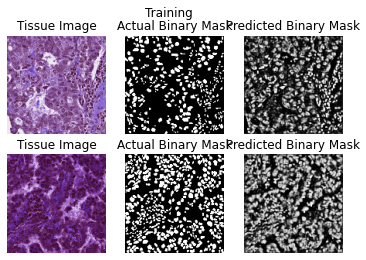

In [ ]:
model.save_weights("UNetW.h5")
gen = Datgen(train_ids, train_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)

result = model.predict(x)
plt.subplot(2,3,1)
plt.title('Tissue Image')
plt.axis('off')
plt.imshow(x[3])
plt.subplot(2,3,2)
plt.title('Actual Binary Mask')
plt.axis('off')
plt.imshow(y[3,:,:,0],cmap='gray')
plt.subplot(2,3,3)
plt.title('Predicted Binary Mask')
plt.axis('off')
plt.imshow(result[3,:,:,0],cmap='gray')

plt.subplot(2,3,4)
plt.title('Tissue Image')
plt.axis('off')
plt.imshow(x[4])
plt.subplot(2,3,5)
plt.title('Actual Binary Mask')
plt.axis('off')
plt.imshow(y[4,:,:,0],cmap='gray')
plt.subplot(2,3,6)
plt.title('Predicted Binary Mask')
plt.axis('off')
plt.imshow(result[4,:,:,0],cmap='gray')
plt.suptitle('Training')
plt.show()

1/1 [==============================] - 0s 391ms/step


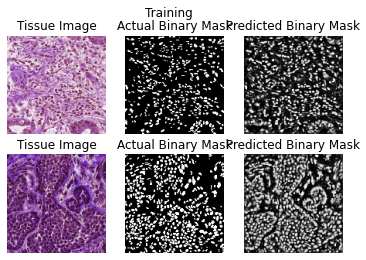

In [ ]:
model.save_weights("UNetW.h5")
gen = Datgen(valid_ids, test_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)

result = model.predict(x)
plt.subplot(2,3,1)
plt.title('Tissue Image')
plt.axis('off')
plt.imshow(x[3])
plt.subplot(2,3,2)
plt.title('Actual Binary Mask')
plt.axis('off')
plt.imshow(y[3,:,:,0],cmap='gray')
plt.subplot(2,3,3)
plt.title('Predicted Binary Mask')
plt.axis('off')
plt.imshow(result[3,:,:,0],cmap='gray')

plt.subplot(2,3,4)
plt.title('Tissue Image')
plt.axis('off')
plt.imshow(x[4])
plt.subplot(2,3,5)
plt.title('Actual Binary Mask')
plt.axis('off')
plt.imshow(y[4,:,:,0],cmap='gray')
plt.subplot(2,3,6)
plt.title('Predicted Binary Mask')
plt.axis('off')
plt.imshow(result[4,:,:,0],cmap='gray')
plt.suptitle('Training')
plt.show()

# Modifying The baseline architecture

##Loss function as a combination of Dice and MS-SSIM with a trade-off parameter

In [ ]:
def dice_ms_ssim(inp,out,tradeoff=0.3):
    return tradeoff*diceloss(inp,out)+(1-tradeoff)*(1-tf.image.ssim_multiscale(inp,out,max_val=4,filter_size=8)) 

In [ ]:
def UNet():
    #feature maps

    filters= [16, 32, 64, 128, 256] #Gives the array of no. of filters used in a block
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)

    return model
model = UNet()
model.compile(optimizer="adam", loss=dice_ms_ssim, metrics=["acc"])

In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=5)

Epoch 1/5
15/15 [==============================] - 48s 3s/step - loss: 0.7699 - acc: 0.5099 - val_loss: 0.8258 - val_acc: 0.5670
Epoch 2/5
15/15 [==============================] - 39s 3s/step - loss: 0.7721 - acc: 0.5094 - val_loss: 0.8258 - val_acc: 0.5670
Epoch 3/5
15/15 [==============================] - 42s 3s/step - loss: 0.7714 - acc: 0.5096 - val_loss: 0.8258 - val_acc: 0.5670
Epoch 4/5
15/15 [==============================] - 42s 3s/step - loss: 0.7746 - acc: 0.5091 - val_loss: 0.8258 - val_acc: 0.5670
Epoch 5/5
15/15 [==============================] - 39s 3s/step - loss: 0.7729 - acc: 0.5093 - val_loss: 0.8258 - val_acc: 0.5670


(8, 128, 128, 1)
1/1 [==============================] - 1s 678ms/step


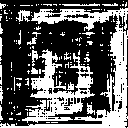

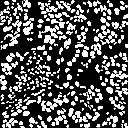

0.31408341632238806

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(train_ids, train_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(y.shape)
result = model.predict(x)
cv2_imshow(result[4]*255)
cv2_imshow(y[4]*255)
result.dtype
dicescore(result,y)

**Though the Dice score is compromised but we get a BETTER SEGMENTATION using a Trade-off between Dice score and MS-SSIM**

##Number of blocks in the UNet architecture

**By Increasing the number of Blocks we observe that the Training time increases but there is slight reduction in mse-loss**

In [ ]:
def UNet():
    #feature maps
    filters = [16, 32, 64, 128, 256,512,1024,2048]
    
    #input to the model
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    c5, p5 = down_block(p4, filters[4]) #image size from 8->4
    c6, p6 = down_block(p5, filters[5]) #image size from 4->2

    bn = bottleneck(p6, filters[6])
    
    u_1 = up_block(bn, c6, filters[5]) #image size from 2 -> 4
    u0 = up_block(u_1, c5, filters[4]) #image size from 4 -> 8
    u1 = up_block(u0, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model
model = UNet()
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["acc"])

In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=20)

Epoch 1/20
15/15 [==============================] - 75s 5s/step - loss: 0.1758 - acc: 0.7056 - val_loss: 0.1436 - val_acc: 0.7792
Epoch 2/20
15/15 [==============================] - 71s 5s/step - loss: 0.1592 - acc: 0.7139 - val_loss: 0.1192 - val_acc: 0.8201
Epoch 3/20
15/15 [==============================] - 63s 4s/step - loss: 0.1388 - acc: 0.7542 - val_loss: 0.0990 - val_acc: 0.8308
Epoch 4/20
15/15 [==============================] - 62s 4s/step - loss: 0.1323 - acc: 0.7680 - val_loss: 0.1028 - val_acc: 0.8312
Epoch 5/20
15/15 [==============================] - 95s 6s/step - loss: 0.1230 - acc: 0.7800 - val_loss: 0.1050 - val_acc: 0.8234
Epoch 6/20
15/15 [==============================] - 70s 5s/step - loss: 0.1176 - acc: 0.7890 - val_loss: 0.1217 - val_acc: 0.7966
Epoch 7/20
15/15 [==============================] - 60s 4s/step - loss: 0.1147 - acc: 0.7944 - val_loss: 0.0855 - val_acc: 0.8492
Epoch 8/20
15/15 [==============================] - 77s 5s/step - loss: 0.1095 - acc: 0.80

###Training Data

(8, 128, 128, 3)
1/1 [==============================] - 1s 818ms/step
[[[0.12912703]
  [0.03032015]
  [0.04728361]
  ...
  [0.14353439]
  [0.13695246]
  [0.20477055]]

 [[0.03697821]
  [0.01839264]
  [0.0787827 ]
  ...
  [0.08063033]
  [0.09317981]
  [0.1667593 ]]

 [[0.07660746]
  [0.5642051 ]
  [0.2992791 ]
  ...
  [0.04007388]
  [0.1527409 ]
  [0.28542495]]

 ...

 [[0.02307943]
  [0.26078188]
  [0.827331  ]
  ...
  [0.7907354 ]
  [0.02256178]
  [0.04501769]]

 [[0.02943717]
  [0.05515524]
  [0.16837458]
  ...
  [0.90592307]
  [0.20931451]
  [0.05811769]]

 [[0.14807868]
  [0.13682647]
  [0.03881819]
  ...
  [0.65524393]
  [0.255708  ]
  [0.21905196]]]


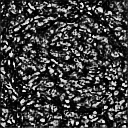

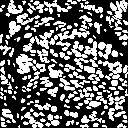

0.5992594828234667

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")


gen = Datgen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)

print(x.shape)
result = model.predict(x)
print(result[5])
cv2_imshow(result[5]*255)
cv2_imshow(y[5]*255)

def dicescore(inp,out,e=1e-6):
    inp=inp.astype('float64')
    out=out.astype('float64')
    inp=inp.ravel()
    out=out.ravel()
    #Flattening input and output and converting them into float

    intersection=np.sum(inp*out)
    dice=(intersection*2 )/(np.sum(inp)+np.sum(out))
    return  dice #returning dice loss

dicescore(result,y)

##Number of Filters

**We observe that by increasing number of filters the training time increases considerably**

In [18]:
def UNet():
    #feature maps

    filters= 4*[16, 32, 64, 128, 256] #Gives the array of no. of filters used in a block
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) #image size from 128 -> 64
    c2, p2 = down_block(p1, filters[1]) #image size from 64 -> 32
    c3, p3 = down_block(p2, filters[2]) #image size from 32 -> 16
    c4, p4 = down_block(p3, filters[3]) #image size from 16->8
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) #image size from 8 -> 16
    u2 = up_block(u1, c3, filters[2]) #image size from 16 -> 32
    u3 = up_block(u2, c2, filters[1]) #image size from 32 -> 64
    u4 = up_block(u3, c1, filters[0]) #image size from 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)

    return model
model = UNet()
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=20)

Epoch 1/20
15/15 [==============================] - 29s 2s/step - loss: 0.1901 - acc: 0.7013 - val_loss: 0.1423 - val_acc: 0.7792
Epoch 2/20
15/15 [==============================] - 27s 2s/step - loss: 0.1679 - acc: 0.7057 - val_loss: 0.1387 - val_acc: 0.7918
Epoch 3/20
15/15 [==============================] - 32s 2s/step - loss: 0.1488 - acc: 0.7336 - val_loss: 0.1108 - val_acc: 0.8292
Epoch 4/20
15/15 [==============================] - 33s 2s/step - loss: 0.1371 - acc: 0.7592 - val_loss: 0.1422 - val_acc: 0.7696
Epoch 5/20
15/15 [==============================] - 28s 2s/step - loss: 0.1290 - acc: 0.7755 - val_loss: 0.0896 - val_acc: 0.8435
Epoch 6/20
15/15 [==============================] - 33s 2s/step - loss: 0.1214 - acc: 0.7831 - val_loss: 0.0938 - val_acc: 0.8409
Epoch 7/20
15/15 [==============================] - 34s 2s/step - loss: 0.1131 - acc: 0.7959 - val_loss: 0.1079 - val_acc: 0.8143
Epoch 8/20
15/15 [==============================] - 32s 2s/step - loss: 0.1091 - acc: 0.80

In [24]:
model.fit(x=u,y=v,batch_size=8, validation_data=valid_gen, epochs=10)

Epoch 1/10
15/15 [==============================] - 27s 2s/step - loss: 0.1048 - acc: 0.8078 - val_loss: 0.0786 - val_acc: 0.8591
Epoch 2/10
15/15 [==============================] - 27s 2s/step - loss: 0.1018 - acc: 0.8120 - val_loss: 0.0713 - val_acc: 0.8696
Epoch 3/10
15/15 [==============================] - 28s 2s/step - loss: 0.0998 - acc: 0.8159 - val_loss: 0.0760 - val_acc: 0.8630
Epoch 4/10
15/15 [==============================] - 26s 2s/step - loss: 0.0979 - acc: 0.8185 - val_loss: 0.0726 - val_acc: 0.8690
Epoch 5/10
15/15 [==============================] - 29s 2s/step - loss: 0.0965 - acc: 0.8201 - val_loss: 0.0886 - val_acc: 0.8437
Epoch 6/10
15/15 [==============================] - 29s 2s/step - loss: 0.0980 - acc: 0.8187 - val_loss: 0.0798 - val_acc: 0.8571
Epoch 7/10
15/15 [==============================] - 26s 2s/step - loss: 0.1018 - acc: 0.8135 - val_loss: 0.1007 - val_acc: 0.8226
Epoch 8/10
15/15 [==============================] - 28s 2s/step - loss: 0.0961 - acc: 0.82

###Training Data

In [25]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
dicescore(result,y)

(8, 128, 128, 3)
1/1 [==============================] - 0s 381ms/step


0.6005047947234107

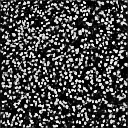

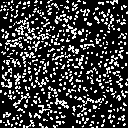

In [ ]:
cv2_imshow(result[6]*255)
cv2_imshow(y[6]*255)

###Testing Data

In [26]:
## Save the Weights
model.save_weights("UNetW.h5")
gen = Datgen(valid_ids, test_path, batch_size=8, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
dicescore(result,y)


(8, 128, 128, 3)
1/1 [==============================] - 0s 381ms/step


0.6234941005971546

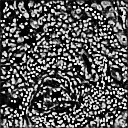

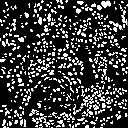

In [27]:
cv2_imshow(result[6]*255)
cv2_imshow(y[6]*255)

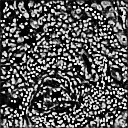

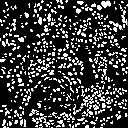

In [51]:
cv2_imshow(result[6]*255)
cv2_imshow(y[6]*255)

#Watershed segmentation on the probability map produced by the UNet to segment individual nuclei

https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html was referred for watershed segmentation

In [134]:
im=result[3]*255
im=im.astype('uint8')
im=np.array(im)
im=np.concatenate((im,im,im),axis=2)
im.shape

(128, 128, 3)

In [135]:
img = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ker=np.ones((3,3),np.uint8)#Using a 3x3 kernel of ones

#Using Otsu's method to determine an optimal global threshold value from the image histogram
r, thr =cv2.threshold(img,0,255,cv2.THRESH_OTSU)


#Finding the background area using dilation
b_g = cv2.dilate(thr,ker,iterations=1)

#Since the nuclei may be touching each other it better to use distance transform and apply a proper threshold rather than using threshold
# Finding foreground area
dist_trans = cv2.distanceTransform(thr,cv2.DIST_L2,5)
r, f_g = cv2.threshold(dist_trans,0.2*dist_trans.max(),255,0)

# Finding unknown region
f_g = np.uint8(f_g)
unknown = cv2.subtract(b_g,f_g)

In [136]:
r, markers = cv2.connectedComponents(f_g)
print(img.shape,markers.shape)

(128, 128) (128, 128)


In [137]:
print(img.dtype)
print(img.shape)
markers = cv2.watershed(im,markers)
i_copy=im.copy()
im[markers == -1] = [255,0,0]

uint8
(128, 128)


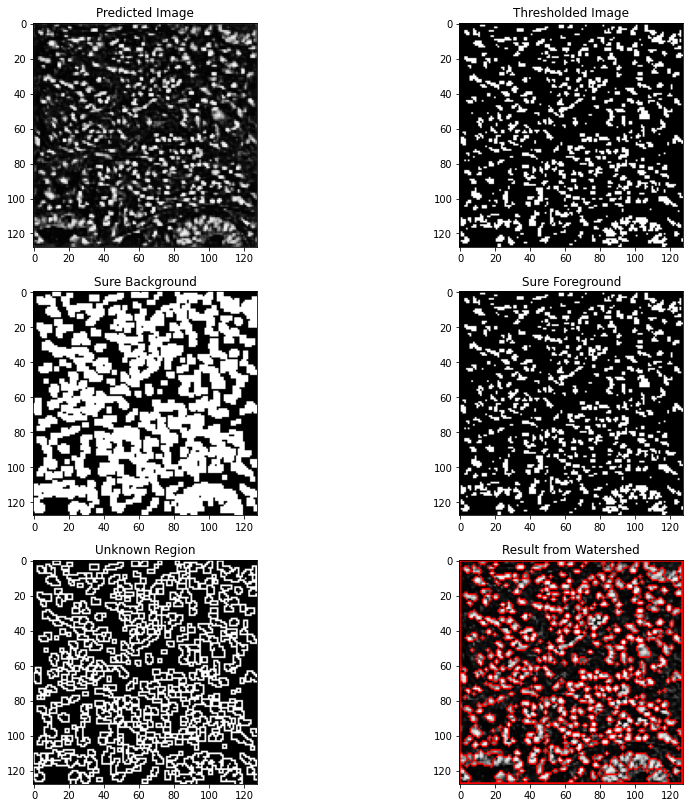

In [119]:
plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
plt.title('Predicted Image')
plt.imshow(i_copy,'gray')
plt.subplot(3,2,2)
plt.title('Thresholded Image')
plt.imshow(thr,'gray')
plt.subplot(3,2,3)
plt.title('Sure Background')
plt.imshow(b_g,'gray')
plt.subplot(3,2,4)
plt.title('Sure Foreground')
plt.imshow(f_g,'gray')
plt.subplot(3,2,5)
plt.title("Unknown Region")
plt.imshow(unknown,'gray')
plt.subplot(3,2,6)
plt.title('Result from Watershed')
plt.imshow(im,'gray')

plt.show()

##Segmentation For Other Predicted Images

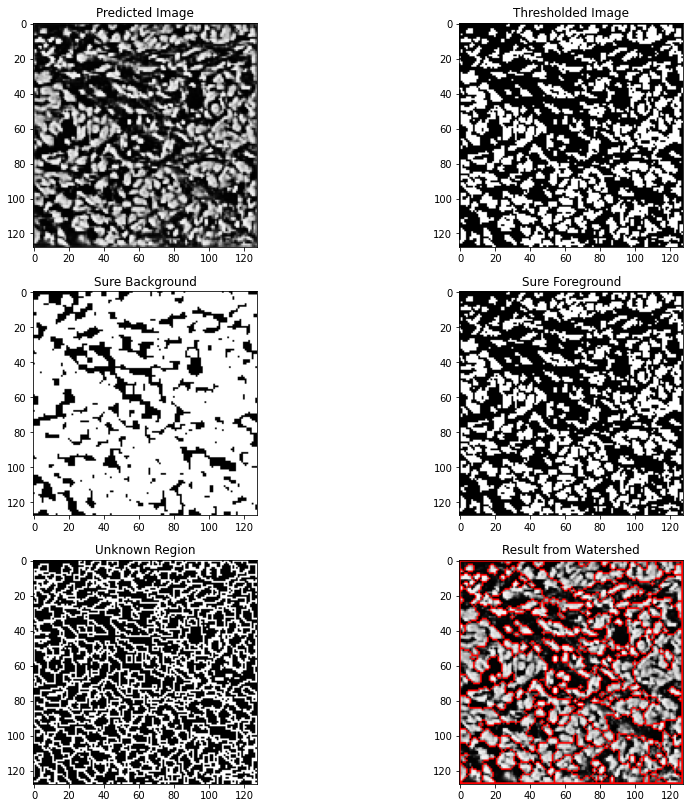

In [138]:
plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
plt.title('Predicted Image')
plt.imshow(i_copy,'gray')
plt.subplot(3,2,2)
plt.title('Thresholded Image')
plt.imshow(thr,'gray')
plt.subplot(3,2,3)
plt.title('Sure Background')
plt.imshow(b_g,'gray')
plt.subplot(3,2,4)
plt.title('Sure Foreground')
plt.imshow(f_g,'gray')
plt.subplot(3,2,5)
plt.title("Unknown Region")
plt.imshow(unknown,'gray')
plt.subplot(3,2,6)
plt.title('Result from Watershed')
plt.imshow(im,'gray')

plt.show()

#Reference Section
https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html referred for watershed segmentation\
https://www.youtube.com/watch?v=QhDlmPhFkNk(Recommended by Sir to watch) was referred for creating the Datagen Block\
I referred Internet for defination of Diceloss